# Bayesian approaches homework - 60 points total

## Part 1:  Bayesian Tomatoes (40 points)

In this part of the assignment, you'll implement the final part of a Naive Bayes classifier that performs sentiment analysis on sentences from movie reviews.  Upload and read the train.tsv file that contains sentences and phrases that have been rated 0 to 4 for sentiment ranging from very negative to very positive.  We'll only be working with the full sentences.

In [ ]:
from google.colab import files

uploaded = files.upload() # upload train.tsv

In [ ]:
import nltk
nltk.download('punkt')  # Data for tokenization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jared\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
with open('train.tsv', 'r') as textfile:
  ratings_data = textfile.read()

In [ ]:
from nltk.tokenize import word_tokenize

def tokenize(sentence):
    """ Returns list of tokens (strings) from the sentence.

    Sets to lowercase and runs NLTK tokenizer.

    Args:
        sentence (string):  the string to tokenize
    """
    return [t.lower() for t in word_tokenize(sentence)]

class ModelInfo:
    """ Contains all counts from the data necessary to do Naive Bayes.

    Attributes:
        word_counts (List[Dict[string,int]]):  counts of tokens, indexed by class
        sentiment_counts (List[int]):  counts of sentences with each sentiment
        total_words (List[int]):  counts of words in each sentiment
        total_examples (int):  total sentence count
    """

    def __init__(self):
        self.word_counts = [{}, {}, {}, {}, {}]
        self.sentiment_counts = [0, 0, 0, 0, 0]
        self.total_words = [0, 0, 0, 0, 0]
        self.total_examples = 0


    def update_word_counts(self, sentence, sentiment):
        """ Consume a sentence and update all counts.

        To "tokenize" the sentence we'll make use of NLTK, a widely-used Python natural language
        processing (NLP) library.  This will handle otherwise onerous tasks like separating periods
        from their attached words.  (Unless the periods are decimal points ... it's more complex
        than you might think.)  The result of tokenization is a list of individual strings that are
        words or their equivalent.

        Args:
            sentence (string):  The example sentence.
            sentiment (int):  The sentiment label.
        """

        # Get the relevant dicts for the sentiment
        s_word_counts = self.word_counts[sentiment]
        tokens = tokenize(sentence)
        for token in tokens:
            self.total_words[sentiment] += 1
            s_word_counts[token] = s_word_counts.get(token, 0) + 1

FIRST_SENTENCE_NUM = 1

def get_models(ratings_data):
    """Returns a model_info object, consuming a string for examples."""
    next_fresh = FIRST_SENTENCE_NUM
    info = ModelInfo()
    for line in ratings_data.splitlines():
        if line.startswith("---"):
            return info
        fields = line.split("\t")
        try:
            sentence_num = int(fields[1])
            if sentence_num <= next_fresh:
                continue
            next_fresh += 1
            sentiment = int(fields[3])
            info.sentiment_counts[sentiment] += 1
            info.total_examples += 1
            info.update_word_counts(fields[2], sentiment)
        except ValueError:
            # Some kind of bad input?  Unlikely with our provided data
            continue
    return info

model_info = get_models(ratings_data)

**(1, 30 points)** Complete naive_bayes_classify(), below.  It should take a ModelInfo object and use the counts stored therein to give the most likely class according to a Naive Bayes calculation, and the log likelihood of that class.  For priors on the sentiment, use the actual frequencies with which each sentiment is used.  Notice that there are 5 different classes to compare.  Use the OUT_OF_VOCAB_PROB constant for any tokens that haven't been seen for a particular sentiment in the data.

In [ ]:

import math
CLASSES = 5
OUT_OF_VOCAB_PROB = 0.0000000001

""" naive_bayes_classify:  takes a ModelInfo containing all counts necessary for classsification
    and a String to be classified.  Returns a number indicating sentiment and a log probability
    of that sentiment (two comma-separated return values).
"""
def naive_bayes_classify(info, sentence):
    """ Use a Naive Bayes model to return sentence's most likely classification and the log prob.

    Args:
        info (ModelInfo):  a ModelInfo containing the counts from the training data
        sentence (string):  the test sentence to classify

    Returns:
        int for the best sentiment
        float for the best log probability (unscaled, just log(prior * product of cond. probs))
    """
    # TODO
    tokens = tokenize(sentence)
    # print(tokens)

    probs = {}
    for i in range(CLASSES):
        probs[i] = math.log(info.sentiment_counts[i]/info.total_examples)

    # print(probs)

    for token in tokens:
        for i in range(CLASSES):
            if(token in info.word_counts[i]):
                # print(info.sentiment_counts[i])
                # print(info.word_counts[i][token])
                # print(info.total_words)
                probs[i] += math.log((info.word_counts[i][token]/info.total_words[i]))
            else:
                probs[i] += math.log(OUT_OF_VOCAB_PROB)

    best_class = 0
    best_log_prob = probs[0]

    print(probs)

    for i in range(CLASSES):
        if(probs[i] > best_log_prob):
            best_class = i
            best_log_prob = probs[i]

    return best_class, best_log_prob

In [ ]:
# Tests
print(naive_bayes_classify(model_info, "I hate this movie")) # Should return 0, -25.9

{0: -25.947997071867018, 1: -26.42142046344062, 2: -26.750060492897077, 3: -28.02585312569834, 4: -28.3894329881918}
(0, -25.947997071867018)


In [ ]:
print(naive_bayes_classify(model_info, "A joyous romp"))    # Should return 4, -22.9

{0: -51.60218440171374, 1: -38.49794752240378, 2: -37.07156563239526, 3: -23.975957160234532, 4: -22.904949886187303}
(4, -22.904949886187303)


In [ ]:
print(naive_bayes_classify(model_info, "notaword")) # Should return 3, -24.3

{0: -25.098642502530314, 1: -24.38159712580945, 2: -24.66474815290163, 3: -24.32724312507062, 4: -24.92254180561146}
(3, -24.32724312507062)


**2, 10 points)** Naive Bayes is sometimes called a "linear" classifier; let's explore why.  Suppose I have two classes $C_1$ and $C_2$ and two observable features A and B; each feature can take on 3 values.  Feature A's conditional distribution is [1/2, 1/4, 1/4] for class 1, [1/4, 1/4, 1/2] for class 2.  Feature B's conditional distribution is [1/4, 1/2, 1/4] for class 1, [1/2, 1/4, 1/4] for class 2.  The two classes each have a prior of 1/2.  Given boolean values (i.e. valued 0 or 1) $a_0$, $a_1$, $a_2$ and $b_0$, $b_1$, $b_2$ to represent the observations of feature A and B, derive an equation for each class that gives the log likelihood of that class given the observations.  (Use base 2 for your logs to make the equations simpler.)  Then, use these log likelihoods to come up with a linear inequality (a weighted sum of $a_0, \ldots, b_2$ that is compared to a constant) that decides whether an example belongs to class 1.

**TODO**
Note: all $\log$ will be base 2.

In order to derive an equation for each class that gives the log likelihood of that class given the observations, we can utilize Bayes Theorem to define the conditional probability of $C_i$ as $P(C_i | a_0, a_1, a_2, b_0, b_1, b_2) = \frac{P(a_0 | C_i)P(a_1|C_i)P(a_2|C_i)P(b_0|C_i)P(b_1|C_i)P(b_2|C_i)P(C_i)}{P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2)}$.

It is possible to get the log likelihood by taking the log of both sides. Then log rules can be applied to simplify the equation, and then we can plug in the known conditional probabilities.

$$
\begin{equation}
  \log(P(C_i | a_0, a_1, a_2, b_0, b_1, b_2)) = \log(\frac{P(a_0 | C_i)P(a_1|C_i)P(a_2|C_i)P(b_0|C_i)P(b_1|C_i)P(b_2|C_i)P(C_i)}{P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2)})\\
  = \log(P(a_0|C_i)) + \log(P(a_1|C_i)) + \log(P(a_2|C_i)) + \log(P(b_0|C_i)) + \log(P(b_1|C_i)) + \log(P(b_2|C_i)) + \log(P(C_i)) - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))
\end{equation}
$$

Using this formula for the conditional probability of $C_i$ given our observations, we can calculate the log likelihood of $\mathbf{P(C_1 | a_0, a_1, a_2, b_0, b_1, b_2)}$ as

$$
\begin{equation}
  = \log(P(a_0|C_1)) + \log(P(a_1|C_1)) + \log(P(a_2|C_1)) + \log(P(b_0|C_1)) + \log(P(b_1|C_1)) + \log(P(b_2|C_1)) + \log(P(C_1)) - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))\\
  = \log(\frac{1}{2}) + \log(\frac{1}{4}) + \log(\frac{1}{4}) + \log(\frac{1}{4}) + \log(\frac{1}{2}) + \log(\frac{1}{4}) + \log(\frac{1}{2}) - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))\\
  = -1 -2 - 2 - 2 - 1 - 2 - 1 - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))
\end{equation}
$$

by plugging in the conditional probabilities given by the conditional distributions of $A$ and $B$ for $C_1$.

We can apply the same formula to find the conditional probability of $C_2$, so the log likelihood of $\mathbf{P(C_2 | a_0, a_1, a_2, b_0, b_1, b_2)}$ is

$$
\begin{equation}
  = \log(P(a_0|C_2)) + \log(P(a_1|C_2)) + \log(P(a_2|C_2)) + \log(P(b_0|C_2)) + \log(P(b_1|C_2)) + \log(P(b_2|C_2)) + \log(P(C_2)) - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))\\
  = \log(\frac{1}{4}) + \log(\frac{1}{4}) + \log(\frac{1}{2}) + \log(\frac{1}{2}) + \log(\frac{1}{4}) + \log(\frac{1}{4}) + \log(\frac{1}{2}) - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))\\
  = -2 - 2 - 1 - 1 - 2 - 2 - 1 - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))
\end{equation}
$$

using the conditional probabilities given by the conditional distributions of $A$ and $B$ for $C_2$.

We can assume that our observations represent $C_1$ if $P(C_1 | a_0,a_1,a_2,b_0,b_1,b_2) > P(C_2|a_0,a_1,a_2,b_0,b_1,b_2)$.

However, due to the fact that $a_0, a_1,$ and $a_2$ are different values that $A$ can take on, if one of the boolean values is true, that means the rest of them are false, thus the conditional probabilities of the other variables should be excluded from the sum. Since each observation variable is a boolean value and is 0 if it's false, we can add each variable as a coefficient before its log probability.

$$
\begin{equation}
  P(C_1|a_0,a_1,a_2,b_0,b_1,b_2) > P(C_2|a_0,a_1,a_2,b_0,b_1,b_2)\\
  -a_01 -a_12 - a_22 - b_02 - b_11 - b_22 - 1 - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2)) > -a_02 - a_12 - a_21 - b_01 - b_12 - b_22 - 1 - \log(P(a_0)P(a_1)P(a_2)P(b_0)P(b_1)P(b_2))\\
  -a_0 -2a_1 - 2a_2 - 2b_0 - b_1 - 2b_2 - 1 > -2a_0 - 2a_1 - a_2 - b_0 - 2b_1 - 2b_2 - 1\\
  a_0 - a_2 - b_0 + b_1 > 0
\end{equation}
$$

Therefore, if $a_0 - a_2 - b_0 + b_1 > 0$, then the observations belong to $C_1$.


## Part 2:  Bayesian Networks in Practice (20 points)

Bayesian networks can capture complex probabilistic relationships and model uncertainty about a variety of aspects of the situation.  "Bayesian statistics" often makes use of them, combining a statistician's knowledge of what distributions occur in nature with Bayesian reasoning about uncertainty given evidence and Bayesian networks' potentially complex relationships between variables.

Here, you'll just answer questions about the example at https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html, a common example used by a Bayesian psychology researcher (Kruschke) to show that Bayesian methods have advantages over traditional statistical hypothesis testing.  The code for this example is reproduced below.  You don't need to decipher everything, but you may need to reference the webpage or do additional digging to answer the questions.

In [ ]:
# Consider running in Google Colab even if you don't usually -
# installing these libraries can cause headaches, and Colab
# already has them installed
#!pip install arviz
#!pip install pymc

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

rng = np.random.default_rng(seed=42)

In [ ]:
iq_drug = np.array([
    101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103,
    100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
    103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100,
    101, 101, 104, 100, 101
])

iq_placebo = np.array([
    99, 101, 100, 101, 102, 100, 97, 101, 104, 101, 102, 102, 100, 105,
    88, 101, 100, 104, 100, 100, 100, 101, 102, 103, 97, 101, 101, 100,
    101, 99, 101, 100, 100, 101, 100, 99, 101, 100, 102, 99, 100, 99
])

df1 = pd.DataFrame({"iq": iq_drug, "group": "drug"})
df2 = pd.DataFrame({"iq": iq_placebo, "group": "placebo"})
indv = pd.concat([df1, df2]).reset_index()

In [ ]:
mu_m = indv.iq.mean()
mu_s = indv.iq.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
    group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)

sigma_low = 10**-1
sigma_high = 10

with model:
    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

    nu_minus_one = pm.Exponential("nu_minus_one", 1 / 29.0)
    nu = pm.Deterministic("nu", nu_minus_one + 1)

with model:
    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2
    group1 = pm.StudentT("drug", nu=nu, mu=group1_mean, lam=lambda_1, observed=iq_drug)
    group2 = pm.StudentT("placebo", nu=nu, mu=group2_mean, lam=lambda_2, observed=iq_placebo)

with model:
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)

In [ ]:
with model:
    idata = pm.sample()

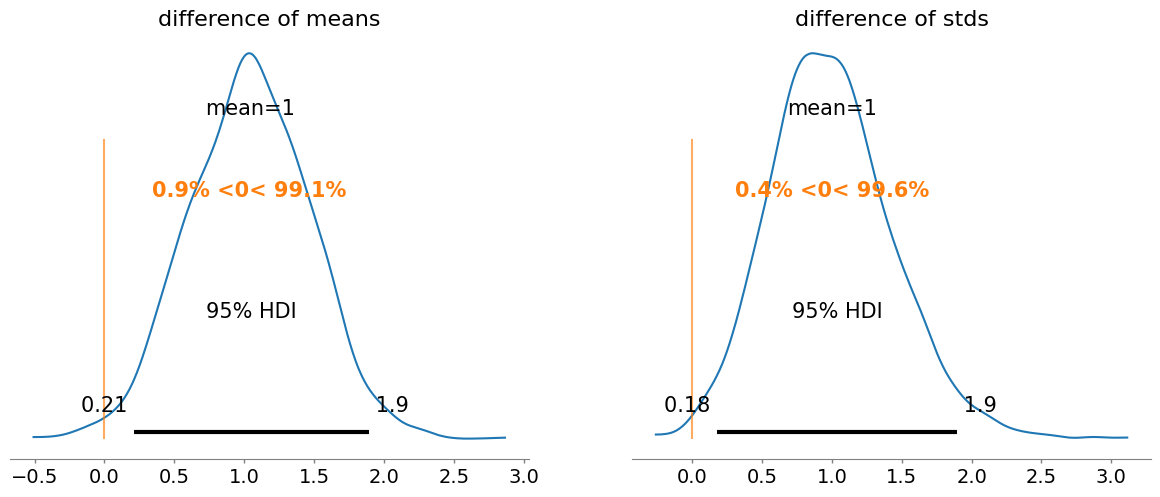

In [ ]:
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds"],
    ref_val=0,
    hdi_prob=0.95,
);

**3, 9 points)** Draw the Bayesian network that is implied by this model - shading circles that represent observed data, putting a box around any circles representing variables that are repeated, and drawing arrows that represent conditional dependence.  The variables you are trying to connect are group1_mean, group2_mean, group1_std, group2_std, nu, iq_drug, iq_placebo, difference_of_means, and difference_of_stds.  (The other values you see are either constants or not important. lambda1 and lambda2 are just transforming standard deviations to precisions, and you can just assume a direct connection through them instead.  *Please submit an image file containing your drawing along with your notebook, even if you try to embed it, as a backup.)*

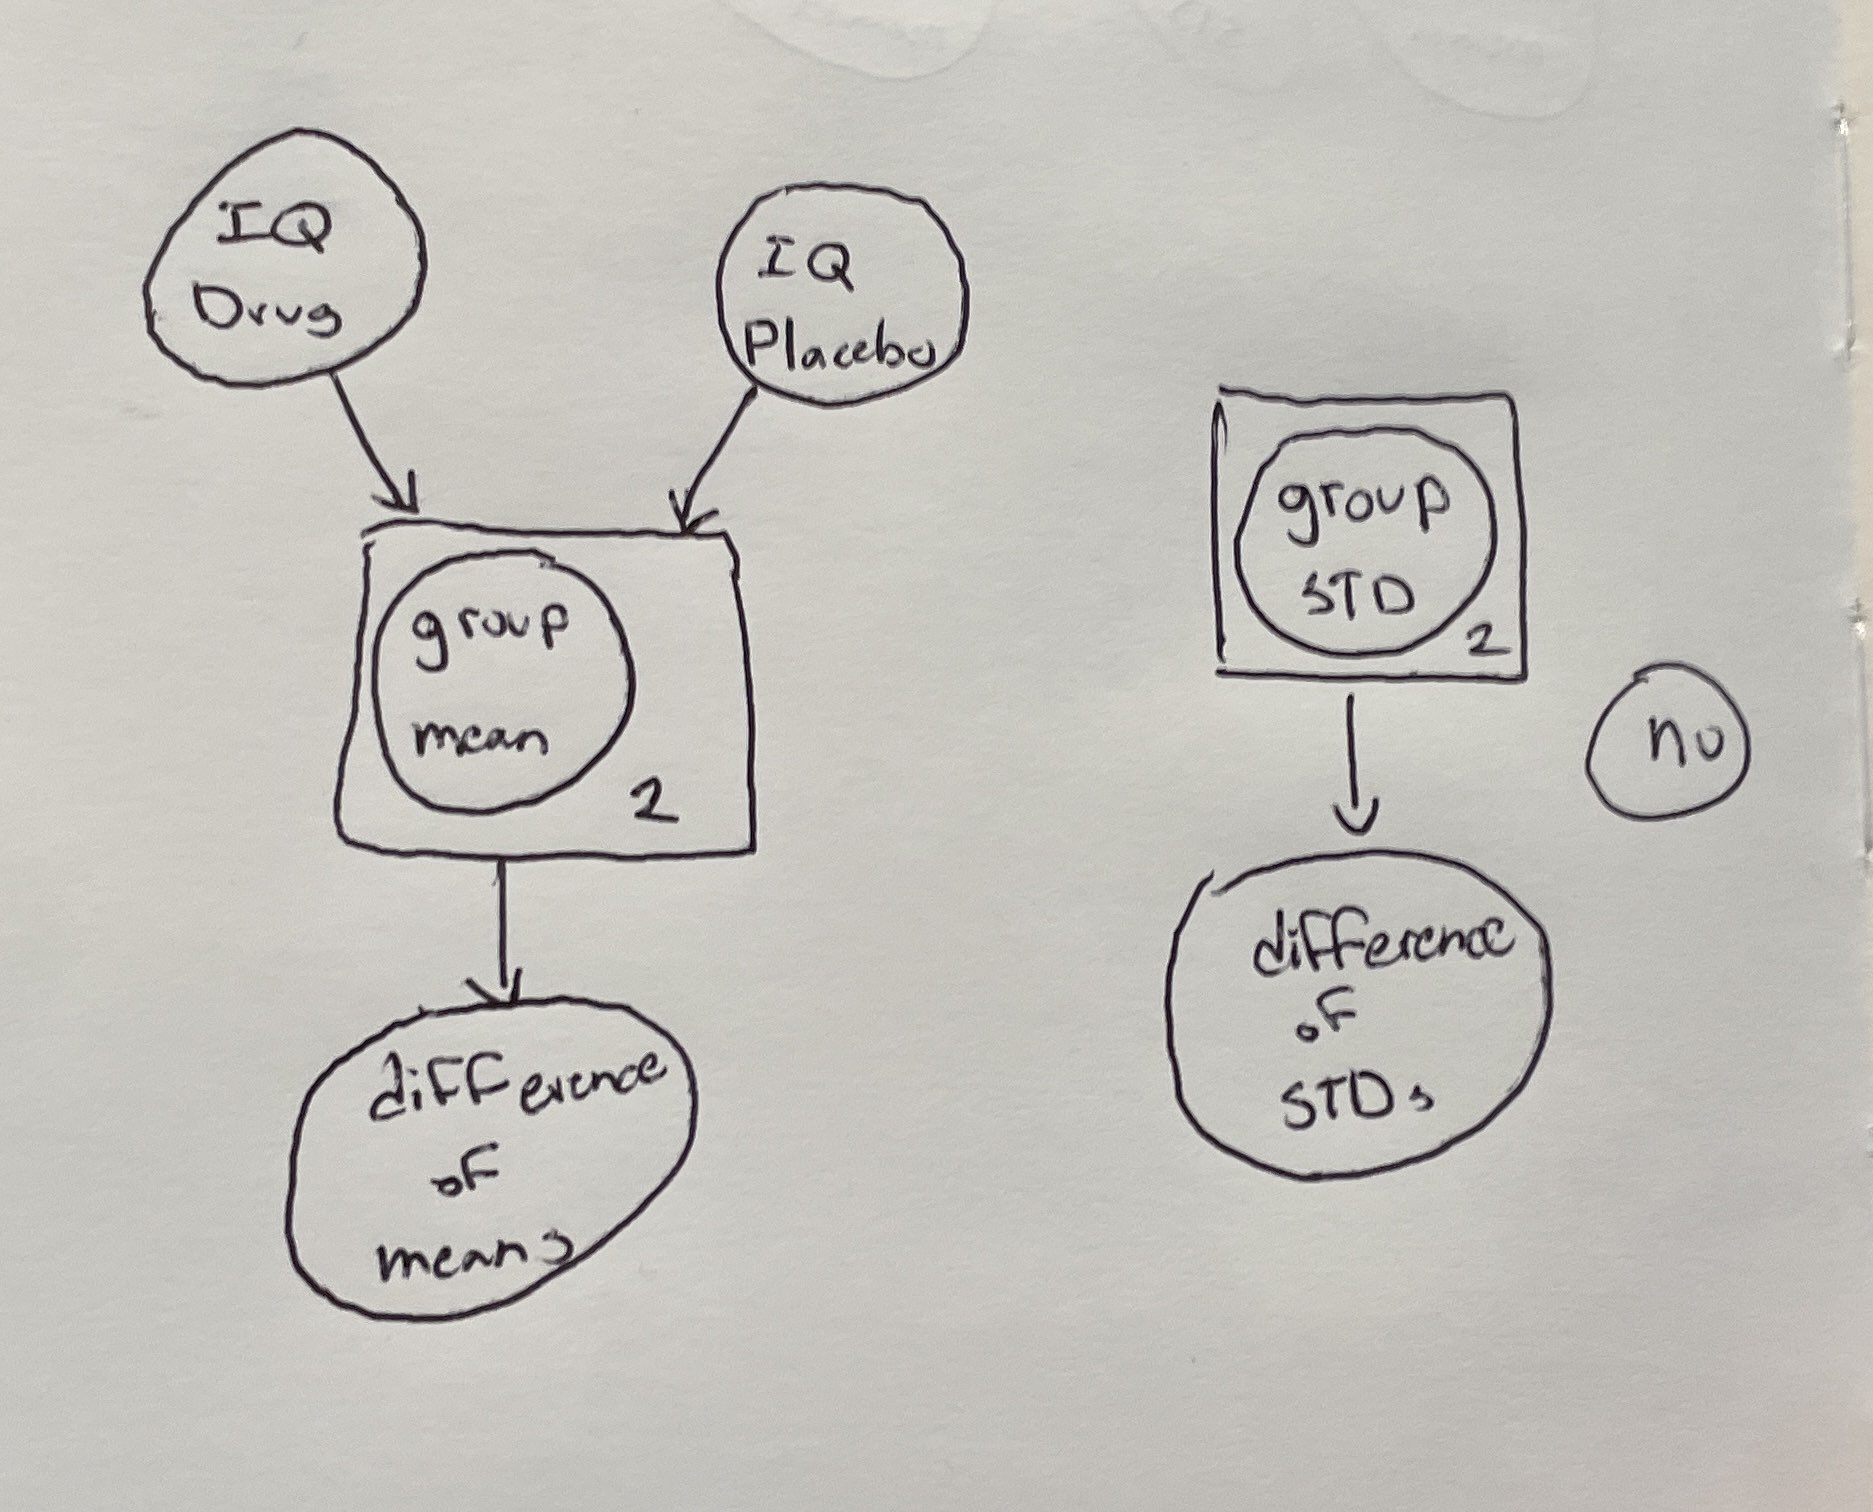**TODO**

**4, 3 points)** Alter the plot_posterior call slightly so that you can find out the probability that the difference in means between the populations is at least 2.  (Hint:  It's currently showing the probability mass on either side of 0.)

**TODO**
The probability that the difference of means between the populations is at least 2 is 0.15.

 **5, 8 points)** A concern we might have about a Bayesian model is that its assumptions about priors and distributions can be a bit arbitrary.  In the code box below, rerun the analysis, but make the following changes:

* group 1 and group 2's means are uniformly distributed between 80 and 120.

* group 1 and group 2's observations are now normally distributed, not $t$ distributions.  (The latter assumption is meant to protect against outliers, because $t$ distributions have long tails.)

Recalculate the probability that the difference in means is at least 2.

In [ ]:
# TODO copy and change the model
with pm.Model() as model:
    group1_mean = pm.Uniform("group1_mean", lower=80, upper=120)
    group2_mean = pm.Uniform("group2_mean", lower=80, upper=120)

sigma_low = 10**-1
sigma_high = 10

with model:
    group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)

with model:
    group1 = pm.Normal("drug", mu=group1_mean, sigma=group1_std)
    group2 = pm.Normal("placebo", mu=group2_mean, sigma=group2_std)

with model:
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)

In [ ]:
with model:
    idata = pm.sample()

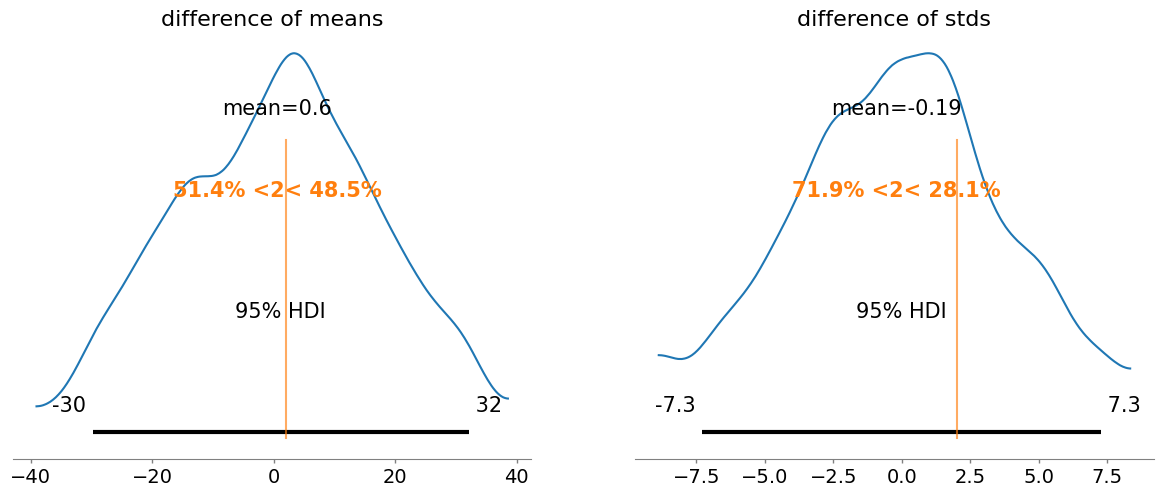

In [ ]:
# TODO copy your modified plot_posterior call here
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds"],
    ref_val=2,
    hdi_prob=0.95,
);

**TODO what is the likelihood of a difference of at least 2 with this model?**
The probability of a difference of at least 2 with this model is 0.485.


**When you're done, use "File->Download .ipynb" and upload your .ipynb file to Blackboard, along with a PDF version (File->Print->Save as PDF) of your assignment.**